In [40]:
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import umap.plot

import SEACells
import h5py
import collections
import scipy.sparse as sp_sparse
from scipy.sparse import csr_matrix, hstack, vstack
import scanpy as sc
import anndata

In [81]:
dataset_dir = '../../data/'
save_dir = '../../data/HECA/'
dataset = "HECA/endometriumAtlasV2_cells_with_counts.h5ad"
dataset_name = "HECA"
switch_dataset = "switch_genelist.csv"
gene_length_dataset = "gene_name_length_EnsemblID.csv"

# Read switches

In [82]:
switch_df = pd.read_csv(dataset_dir + switch_dataset, index_col=0)
# drop first column
switch_df = switch_df.drop(switch_df.columns[0], axis=1)

# switch df to dict
switch_dict = {}
for row in switch_df.index:
	switch_dict[row] = switch_df.loc[row].dropna().tolist()

# Read Reference Matrix

In [84]:
adata = sc.read_h5ad(dataset_dir + dataset)
adata

AnnData object with n_obs × n_vars = 313527 × 17736
    obs: 'n_genes', 'sample', 'library', 'Processing', 'Treatment', '10x kit', 'percent_mito', 'n_counts', 'scrublet_score', 'genotype', 'Library_genotype', 'Group', 'Endometriosis_stage', 'Hormonal treatment', 'Binary Stage', 'Stage', 'phase', 'dataset', 'Biopsy_type', 'Tissue_sampled', 'Age', 'Endometrial_pathology', 'celltype', 'lineage', 'label_long'
    var: 'gene_ids-0-Fonseca', 'feature_types-0-Fonseca', 'n_cells-0-Fonseca', 'gene_ids-1-Fonseca', 'feature_types-1-Fonseca', 'n_cells-1-Fonseca', 'gene_ids-2-Fonseca', 'feature_types-2-Fonseca', 'n_cells-2-Fonseca', 'gene_ids-3-Fonseca', 'feature_types-3-Fonseca', 'n_cells-3-Fonseca', 'gene_ids-4-Fonseca', 'feature_types-4-Fonseca', 'n_cells-4-Fonseca', 'gene_ids-5-Fonseca', 'feature_types-5-Fonseca', 'n_cells-5-Fonseca', 'gene_ids-6-Fonseca', 'feature_types-6-Fonseca', 'n_cells-6-Fonseca', 'MT-Fonseca', 'n_cells_by_counts-Fonseca', 'mean_counts-Fonseca', 'pct_dropout_by_counts-Fon

In [85]:
# make var names unique
adata.var_names_make_unique()

In [86]:
adata.X = csr_matrix(adata.X)

In [87]:
raw_ad = sc.AnnData(adata.X)
raw_ad.obs_names, raw_ad.var_names = adata.obs_names, adata.var_names
adata.raw = raw_ad

In [88]:
# calculate total counts per sample
adata.obs['total_counts'] = adata.X.sum(axis=1)

In [110]:
# load gene length data
gene_length = pd.read_csv(dataset_dir + gene_length_dataset, index_col=0)
gene_length.columns = ['gene_length', 'gene_name']
gene_length.index = gene_length['gene_name']
gene_length.shape

(19593, 2)

In [112]:
# drop genes in adata that are not in gene_length
gene_length = gene_length[gene_length.index.isin(adata.var_names)]
adata = adata[:, adata.var_names.isin(gene_length.index)]

In [113]:
adata

View of AnnData object with n_obs × n_vars = 313527 × 15684
    obs: 'n_genes', 'sample', 'library', 'Processing', 'Treatment', '10x kit', 'percent_mito', 'n_counts', 'scrublet_score', 'genotype', 'Library_genotype', 'Group', 'Endometriosis_stage', 'Hormonal treatment', 'Binary Stage', 'Stage', 'phase', 'dataset', 'Biopsy_type', 'Tissue_sampled', 'Age', 'Endometrial_pathology', 'celltype', 'lineage', 'label_long', 'total_counts'
    var: 'gene_ids-0-Fonseca', 'feature_types-0-Fonseca', 'n_cells-0-Fonseca', 'gene_ids-1-Fonseca', 'feature_types-1-Fonseca', 'n_cells-1-Fonseca', 'gene_ids-2-Fonseca', 'feature_types-2-Fonseca', 'n_cells-2-Fonseca', 'gene_ids-3-Fonseca', 'feature_types-3-Fonseca', 'n_cells-3-Fonseca', 'gene_ids-4-Fonseca', 'feature_types-4-Fonseca', 'n_cells-4-Fonseca', 'gene_ids-5-Fonseca', 'feature_types-5-Fonseca', 'n_cells-5-Fonseca', 'gene_ids-6-Fonseca', 'feature_types-6-Fonseca', 'n_cells-6-Fonseca', 'MT-Fonseca', 'n_cells_by_counts-Fonseca', 'mean_counts-Fonseca', 'p

In [115]:
# add gene length to adata
adata.var['gene_length'] = gene_length.loc[adata.var_names, "gene_length"].values

/var/folders/mp/0ylvhbys7zl0gsbx35x33lfw0000gp/T/ipykernel_44739/1063740930.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['gene_length'] = gene_length.loc[adata.var_names, "gene_length"].values


In [116]:
# Calculate RPKM
adata.X = adata.X / (adata.obs['total_counts'].values[:, None] / 1e6) / (adata.var['gene_length'].values / 1e3)

: 

In [15]:
# # save rpkm as csv
# rpkm = pd.DataFrame(adata.X.toarray().T, index=adata.var_names, columns=adata.obs_names)
# rpkm.to_csv(save_dir + 'rpkm.csv')

# Clustering pipeline

## Create anndata for genes in JS

In [16]:
REPRESENT = "gene"

In [17]:
adata.X = csr_matrix(adata.X)

In [18]:
# take log2 of RPKM+1
sc.pp.log1p(adata, base=2)

# compute highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=3660, subset=False) # n_top_genes = 36601 * 0.1

In [19]:
# calculate reference genes

rab7a = adata[:, adata.var_names.isin(['RAB7A'])].X.toarray()
gapdh = adata[:, adata.var_names.isin(['GAPDH'])].X.toarray()
actp = adata[:, adata.var_names.isin(['ACTB'])].X.toarray()

ref_norm = (rab7a + gapdh + actp) * (1/3)
ref_norm.min(), ref_norm.max()

(0.0, 10.249852655557493)

In [20]:
# calculate jane score:
# 10 + log2(RPKM) - log2(geomean(RAB7A+1, GAPDH+1, ACTB+1)) if RPKM > 0
# 0 if RPKM == 0

for obs in range(adata.X.shape[0]):
	nonzeros = adata.X[obs].nonzero()
	adata.X[obs][nonzeros] = adata.X[obs][nonzeros] - ref_norm[obs] + 10

In [21]:
adata = adata[:, adata.var['highly_variable']]

In [22]:
# save adata as tsv
pd.DataFrame(adata.X.toarray().T, columns=adata.obs_names, index=adata.var_names).to_csv(save_dir + "js_gene.csv", sep='\t')

In [23]:
adata_processed = adata
adata_processed

View of AnnData object with n_obs × n_vars = 1905 × 3660
    obs: 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_length', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [24]:
PCA_ncomps = 1000

## Create anndata for switches in JS

In [54]:
REPRESENT = "switch"

In [55]:
adata.X = csr_matrix(adata.X)

In [56]:
# take log2 of RPKM+1
sc.pp.log1p(adata, base=2)

In [57]:
# calculate reference genes

rab7a = adata[:, adata.var_names.isin(['RAB7A'])].X.toarray()
gapdh = adata[:, adata.var_names.isin(['GAPDH'])].X.toarray()
actp = adata[:, adata.var_names.isin(['ACTB'])].X.toarray()

ref_norm = (rab7a + gapdh + actp) * (1/3)
ref_norm.min(), ref_norm.max()

(0.0, 10.249852655557493)

In [58]:
adata.obs['ref_norm'] = ref_norm

In [59]:
# calculate jane score:
# 10 + log2(RPKM) - log2(geomean(RAB7A+1, GAPDH+1, ACTB+1)) if RPKM > 0
# 0 if RPKM == 0

for obs in range(adata.X.shape[0]):
	nonzeros = adata.X[obs].nonzero()
	adata.X[obs][nonzeros] = adata.X[obs][nonzeros] - ref_norm[obs] + 10

In [60]:
# compare genes in switches with genes in rpkm
switch_genes = [gene for switch in switch_dict.keys() for gene in switch_dict[switch]]
# change to set
switch_genes = set(switch_genes)
rpkm_genes = set(adata.var_names)

# find overlapping genes
overlapping_genes = switch_genes.intersection(rpkm_genes)
print(len(switch_genes), len(rpkm_genes), len(overlapping_genes))

5079 19154 4980


In [61]:
# filter non-overlapping genes from switches
for switch in switch_dict.keys():
	switch_dict[switch] = list(set(switch_dict[switch]).intersection(overlapping_genes))

In [62]:
# aggregate rpkm columns using switch_dict
m_li = []
for switch in switch_dict.keys():
	m = adata[:, adata.var_names.isin(switch_dict[switch])].X.mean(axis=1)
	m_li.append(csr_matrix(m))

final_m = hstack(m_li)

In [63]:
# saving js switch data
pd.DataFrame(final_m.toarray().T, columns=adata.obs_names, index=switch_dict.keys()).to_csv(save_dir + "js_switch.csv", sep='\t')

In [64]:
# convert data to AnnData
adata_processed = anndata.AnnData(final_m)
adata_processed.X

<1905x489 sparse matrix of type '<class 'numpy.float64'>'
	with 492719 stored elements in Compressed Sparse Row format>

In [65]:
adata_processed.obs_names = adata.obs_names
adata_processed.var_names = switch_dict.keys()

In [66]:
PCA_ncomps = 90

## SEACells Clustering and UMAP

In [67]:
sc.tl.pca(adata_processed, n_comps=PCA_ncomps)

In [68]:
cumsum = np.cumsum(adata_processed.uns['pca']['variance_ratio'])
print("#", np.count_nonzero(cumsum < 0.95), "PC's capture 95% of variance")

# 90 PC's capture 95% of variance


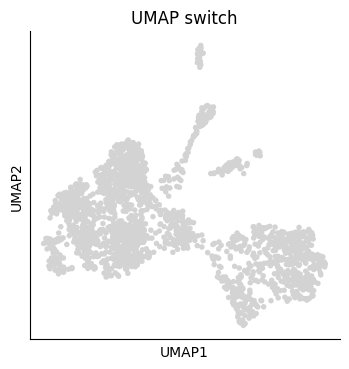

In [69]:
sc.pp.neighbors(adata_processed)
sc.tl.umap(adata_processed)
sc.pl.umap(adata_processed, save=f'_{dataset_name}_{REPRESENT}.png', title=f'UMAP {REPRESENT}')

### Run SEACells

In [70]:
## Core parameters
n_SEACells = 15
build_kernel_on = 'X_pca'

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells !!not sure how to tune

In [71]:
model = SEACells.core.SEACells(adata_processed,
                  build_kernel_on=build_kernel_on,
                  n_SEACells=n_SEACells,
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [72]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/1905 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/1905 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/1905 [00:00<?, ?it/s]

Constructing CSR matrix...


In [73]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 9 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 16/16 [00:00<00:00, 665.25it/s]

Selecting 6 cells from greedy initialization.


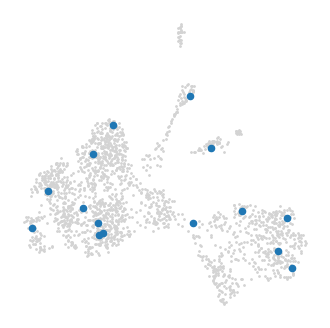

In [74]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(adata_processed, model)

In [75]:
model.fit(min_iter=10, max_iter=100)

Randomly initialized A matrix.
Setting convergence threshold at 0.00077
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 23 iterations.


### Assessing results

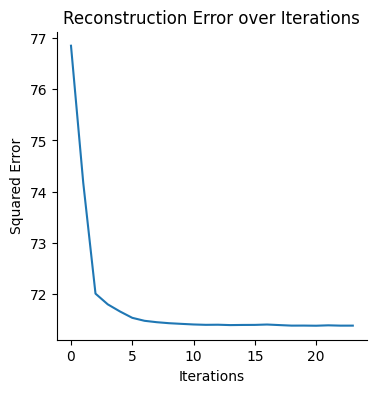

In [76]:
# Check for convergence
model.plot_convergence()

In [77]:
model.get_hard_assignments().head()

,SEACell
index,
AAACCCAAGCAGCACA-1,SEACell-5
AAACGAAAGACCGTTT-1,SEACell-9
AAACGAAAGGGCGAAG-1,SEACell-10
AAACGCTTCCTCGCAT-1,SEACell-1
AAAGAACAGGGAGGAC-1,SEACell-6


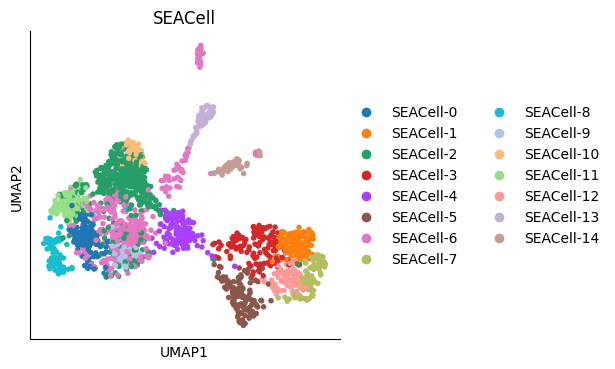

In [78]:
sc.pl.umap(adata_processed, color='SEACell', save=f'_SEACells_{dataset_name}_{REPRESENT}.png')

/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/SEACells/plot.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)
/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/SEACells/plot.py:121: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


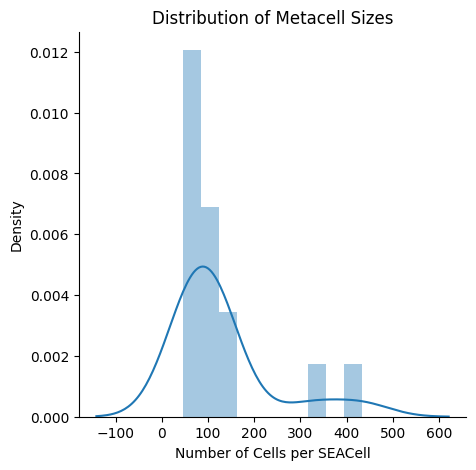

/Users/CJChen/Desktop/PeerLab/probablistic-model/venv/lib/python3.11/site-packages/SEACells/plot.py:131: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return pd.DataFrame(label_df.groupby('SEACell').count().iloc[:, 0]).rename(columns={'index':'size'})


,size
SEACell,
SEACell-0,128
SEACell-1,114
SEACell-2,433
SEACell-3,120
SEACell-4,120
SEACell-5,126
SEACell-6,321
SEACell-7,77
SEACell-8,67


In [79]:
SEACells.plot.plot_SEACell_sizes(adata_processed, bins=10)

# Saving Results

In [80]:
model.get_hard_assignments().to_csv(save_dir + f'SEACell_assignments_{REPRESENT}.csv', sep='\t')